In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn import preprocessing

%matplotlib inline

## Loading data

In [2]:
df = pd.read_csv('CrowdstormingDataJuly1st.csv')

## Cleaning / Aggregating data

First, we drop the rows with no skin color ratings.

In [3]:
df = df.dropna(subset=['rater1', 'rater2'])

Then, we aggregate the dataframe by player.

- We keep the first values for the columns `playerShort`, `height`, `weight`, `club` and `leagueCountry`.
- We sum the number of `games`.
- We compute the ratio of `victories`, `defeats`, `ties`, `goals`, `yellowCards` and `redCards` per game.
- We take the mean of the `rater1` and `reater2` means to create a new feature named `skinColor`. 

In [4]:
def aggregate(x):
    return pd.DataFrame({
        'playerShort': x.playerShort,
        'height': x.height,
        'weight': x.weight,
        'club': x.club,
        'leagueCountry': x.leagueCountry,
        'games': x.games.sum(),
        'victories': x.victories.sum() / x.games.sum(),
        'defeats': x.defeats.sum() / x.games.sum(),
        'ties': x.ties.sum() / x.games.sum(),
        'goals': x.goals.sum() / x.games.sum(),
        'yellowCards': x.yellowCards.sum() / x.games.sum(),
        'yellowReds': x.yellowReds.sum() / x.games.sum(),
        'redCards': x.redCards.sum() / x.games.sum(),
        'skinColor': (x.rater1.mean() + x.rater2.mean()) / 2
    })

In [5]:
agg_df = df.groupby('playerShort').apply(aggregate).drop_duplicates(subset='playerShort', keep='first').reset_index(drop=True)

- To deal with the missing values in the columns `height` and `weight`, we fill the rows with the median value.
- As our goal is to fit a `RandomForestClassifier` with the data, we convert the categorical features to integers with a `LabelEncoder` per feature.
- We drop the `playerShort` column as we already use it to aggregate the dataframe.
- We binarize the `skinColor` column.

In [6]:
def process_df(df, categorical_features):
    df['height'] = df['height'].fillna(value=df['height'].median())
    df['weight'] = df['weight'].fillna(value=df['weight'].median())
    
    for feature in categorical_features:
        le = preprocessing.LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    df = df.drop(['playerShort'], axis=1)
    
    df['skinColor'] = df['skinColor'].apply(lambda x: x >= 0.5)
    
    return df

In [7]:
agg_df = process_df(agg_df, ['club', 'leagueCountry'])

## Machine Learning

First, we need to get the output column that we want to predict (here, `skinColor`).

In [8]:
y = agg_df.pop('skinColor')

Then, we initialize our classifier and validate it with a 10-fold cross validation.

In [9]:
clf = RandomForestClassifier(n_estimators=100)
cross_val_score(clf, agg_df, y, cv=10)

array([ 0.7672956 ,  0.72955975,  0.71069182,  0.75471698,  0.77358491,
        0.7278481 ,  0.78481013,  0.77848101,  0.75949367,  0.81012658])

The variance between the folds is pretty low. We can conclude that with the features we selected, there is no overfitting.

Let's take a look at the features importance.

In [20]:
def show_features_ranking(X, y):
    clf = clf = RandomForestClassifier(n_estimators=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf.fit(X_train, y_train)

    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(agg_df.shape[1]):
        print("%d. %s (%f)" % (f + 1, X.columns[f], importances[indices[f]]))

In [21]:
show_features_ranking(agg_df, y)

Feature ranking:
1. club (0.104644)
2. defeats (0.104089)
3. games (0.097592)
4. goals (0.092857)
5. height (0.088952)
6. leagueCountry (0.088876)
7. redCards (0.077660)
8. ties (0.076473)
9. victories (0.073894)
10. weight (0.072370)
11. yellowCards (0.069845)
12. yellowReds (0.052748)


Let's take a look at the learning curves now

In [18]:
def show_learning_curve(X, y):
    clf = RandomForestClassifier(n_estimators=100)
    train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=20, train_sizes=range(200, 1400, 200))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title("Learning curves (RandomForestClassifier, n_estimators=100)")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy score")
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

    plt.show()

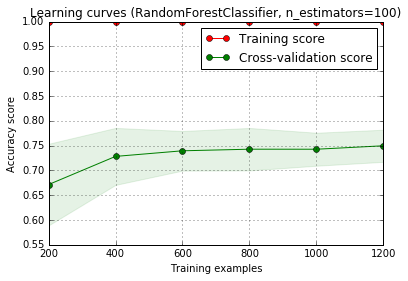

In [19]:
show_learning_curve(agg_df, y)